<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Первичный-анализ" data-toc-modified-id="Первичный-анализ-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Первичный анализ</a></span></li><li><span><a href="#Посмотрим-как-ведет-себя-скользящее-среднее" data-toc-modified-id="Посмотрим-как-ведет-себя-скользящее-среднее-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Посмотрим как ведет себя скользящее среднее</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>XGBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#Результат" data-toc-modified-id="Результат-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Результат</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
# !pip install pystan prophet

In [2]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# import stan
# from prophet import Prophet

import xgboost as xgb

import matplotlib.pyplot as plt

# from prophet.plot import add_changepoints_to_plot

## Подготовка

In [3]:
df_raw = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df_raw.sort_index(inplace=True)
df_raw.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


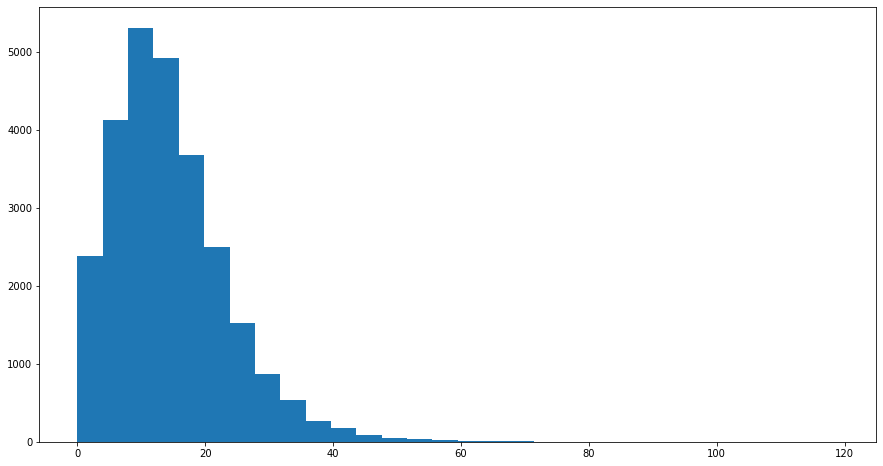

In [5]:
plt.figure(figsize=(15, 8))
plt.hist(df_raw['num_orders'], bins=30)
plt.show()

Проверим пропуски

In [6]:
df_raw.isna().sum()

num_orders    0
dtype: int64

## Анализ

### Первичный анализ

Сделаем семплирование по часу

In [7]:
df = df_raw.resample('1H').sum()

In [8]:
df_raw.shape, df.shape

((26496, 1), (4416, 1))

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен. Ресемплинг был сделан верно.
</div>

Размерность массива уменьшилась в 5 раз

Проведем декомпозицию

<div class="alert alert-block alert-info">
<b>Совет: </b> Почему в 5?
</div>

In [9]:
df_raw.shape[0]/df.shape[0]

6.0

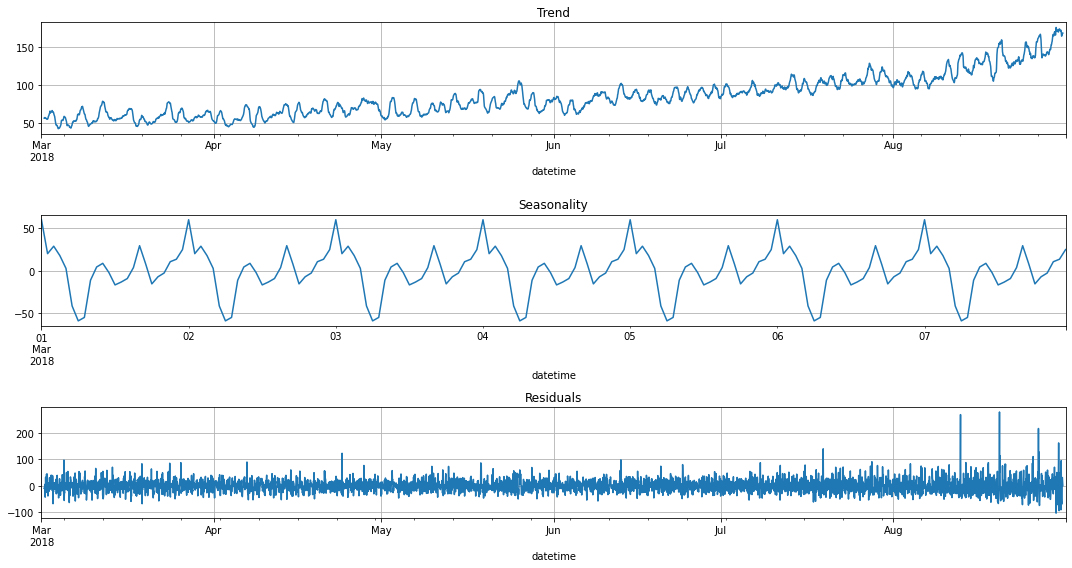

In [10]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.grid(True)
plt.subplot(312)
decomposed.seasonal.head(24*7).plot(ax=plt.gca())
plt.title('Seasonality')
plt.grid(True)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.grid(True)
plt.tight_layout()

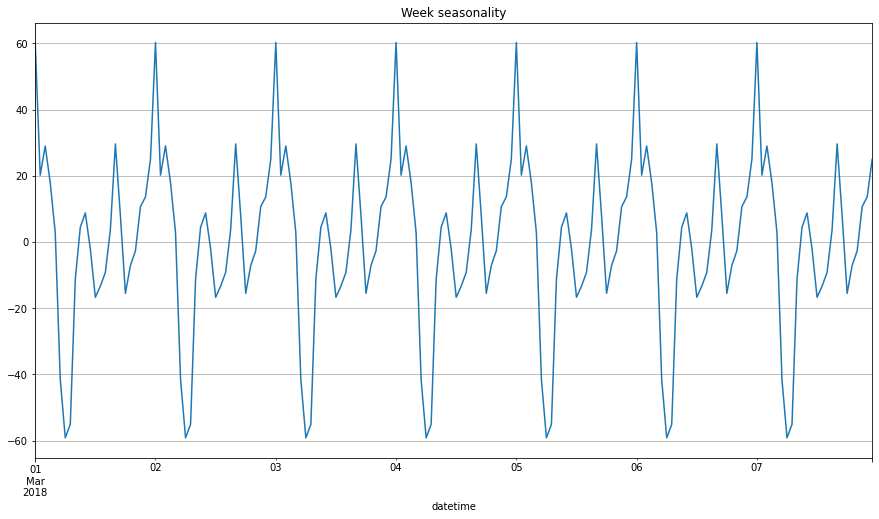

In [11]:
plt.figure(figsize=(15, 8))
decomposed.seasonal.head(24*7).plot(ax=plt.gca())
plt.title('Week seasonality')
plt.grid(True)
plt.show()

По графику можно предположить что тренд восходящий. 
Присутствует сезонность с периодом в день - каждый день картины повторяется, в течение дня есть несколько пиков 
- в районе 9 утра (люди едут на работу)
- в районе 4-5 часов (люди едут с работы, до пробок)
- в районе 12 часов ночи и в районе 2 часов ночи - возвращение домой после пабов, гостей, сверхурочной работы, etc

По графикам можно предположить что ряд стационарный.

Для большей уверености проверим ряд на стационарность c помощью теста Дики-Фуллера:

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана верно. Хорошо, что сезонность была визуализирована на более коротком интервале!
</div>

In [12]:
def adfuller_test(series, signif=0.05):
    """
    Perform Augmented Dickey-Fuller to test for Stationarity of the given series
    and print report. Null Hypothesis: Data has unit root and is non-stationary.

    series: time series in pd.Series format
    signif: significance level for P-value to reject Null Hypothesis
    """
    x = adfuller(series, autolag='AIC')

    output = {'Test Statistic': x[0], 
              'P-value': x[1], 
              'Number of lags': x[2], 
              'Number of observations': x[3],
              f'Reject (signif. level {signif})': x[1] < signif }

    for key, val in x[4].items():
         output[f'Critical value {key}'] = val

    return pd.Series(output)


adfuller_test(df.num_orders)

Test Statistic                -3.068924
P-value                         0.02894
Number of lags                       30
Number of observations             4385
Reject (signif. level 0.05)        True
Critical value 1%             -3.431842
Critical value 5%             -2.862199
Critical value 10%            -2.567121
dtype: object

Гипотеза о нестационарности временного ряда отвергнута

### Посмотрим как ведет себя скользящее среднее

Посмотрим на месяц

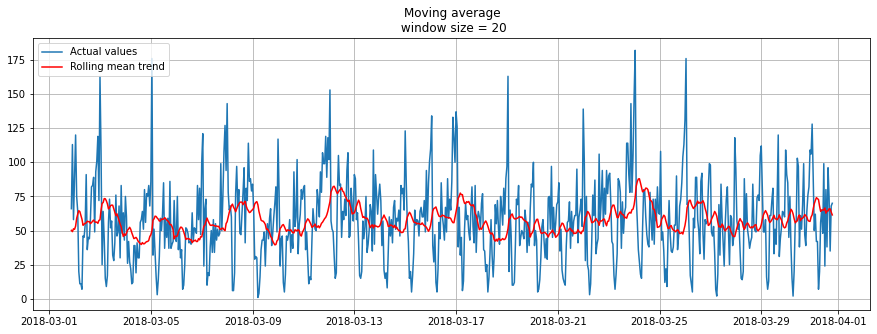

In [13]:
dt = 24*30
n = 20

series=df.num_orders

rolling_mean = series.rolling(window=n).mean().shift(1)

plt.figure(figsize=(15,5))
plt.title("Moving average\n window size = {}".format(n))
plt.plot(series[n+1:n+dt], label="Actual values")
plt.plot(rolling_mean[n+1:n+dt], "r", label="Rolling mean trend")

plt.legend(loc="upper left")
plt.grid(True)

Посчитаем MSE для скользящего среднего

In [14]:
rolling_mean_rmse = mean_squared_error(rolling_mean[n:], series[n:], squared=False)
print(rolling_mean_rmse)

39.539022805145365


Разобьем данные на трейн и тест

In [15]:
train, test = train_test_split(df, test_size=0.1, shuffle=False)

In [16]:
train

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-13 09:00:00,137
2018-08-13 10:00:00,156
2018-08-13 11:00:00,144


In [17]:
test

,num_orders
datetime,
2018-08-13 14:00:00,102
2018-08-13 15:00:00,175
2018-08-13 16:00:00,144
2018-08-13 17:00:00,152
2018-08-13 18:00:00,104
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Обучение

### LinearRegression

Используем линейную модель

Для линейной модели создадим дополнительные признаки

Напишем функцию, добавляющую дополнительные признаки в датасет, и разбивающую его при необходимости

In [18]:
def prepare_data(data, lags, split=True, test_size=0.1):
    
    data = pd.DataFrame(data.copy())
    data.columns = ['y']
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for ll in lags:
        data['lag_{}'.format(ll)] = data.y.shift(ll)
        

    data['hour'] = data.index.hour
    data['weekday'] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    if split:
        # разбиваем весь датасет на тренировочную и тестовую выборку
        X_train = data.loc[:test_index].drop(["y"], axis=1)
        y_train = data.loc[:test_index]["y"]
        X_test = data.loc[test_index:].drop(["y"], axis=1)
        y_test = data.loc[test_index:]["y"]

        return X_train, X_test, y_train, y_test
    else:
        X = data.drop(["y"], axis=1)
        y = data["y"]
        return X, y
        

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично!
</div>

In [19]:
X_train, X_test, y_train, y_test = prepare_data(train.num_orders, lags = [1, 2, 3], split=True, test_size=0.1)

Перед тем как тренировать модель посмотрим какие лаги имеют наибольшую корреляцию между собой

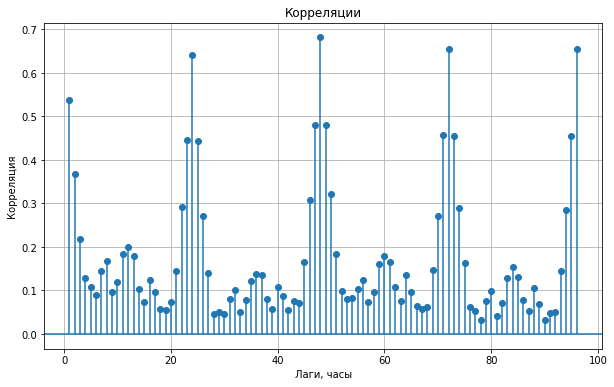

In [20]:
y_train_series = pd.Series(data=np.array(y_train), index=df.num_orders.index[:len(y_train)])


n_lags = 96
corr_list = []
for i_lag in range(1,n_lags+1):
    corr_list.append(np.corrcoef(y_train_series[i_lag:], y_train_series.shift(i_lag)[i_lag:])[0,1])
plt.figure(figsize=(10,6))
plt.vlines(range(1,n_lags+1), [0], corr_list)
plt.axhline()
plt.plot(range(1, n_lags+1), corr_list, 'o')
plt.title('Корреляции')
plt.xlabel('Лаги, часы')   
plt.ylabel('Корреляция')
plt.grid(True)
plt.show()

Наибольшая корреляция наблюдается в между замерами с интервалом 24 часа - что логично. То есть брать больше чем 24 лага нет смысла - они начнут коррелировать.

In [21]:
def linear_regression(lags, plot=True):
    X_train, X_test, y_train, y_test = prepare_data(train.num_orders, lags = lags, split=True, test_size=0.1)

    model = LinearRegression()
    model.fit(X_train, y_train)

    prediction = model.predict(X_test)

    linear_rmse = mean_squared_error(prediction, y_test, squared=False)

    if plot:
        plt.figure(figsize=(15, 8))
        plt.plot(prediction, "r", label="prediction")
        plt.plot(y_test.values, label="actual")
        plt.legend(loc="best")
        plt.title(f"Linear regression\n Mean squared error {linear_rmse}")
        plt.grid(True)
        print(f"RMSE for linear regression {linear_rmse}")
    
    return model, linear_rmse

Посмотрим на качество модели в зависимости от частоты лагов

Возьмем два набора лагов - с интервалом в 3 часа и с интервалом в 1 час

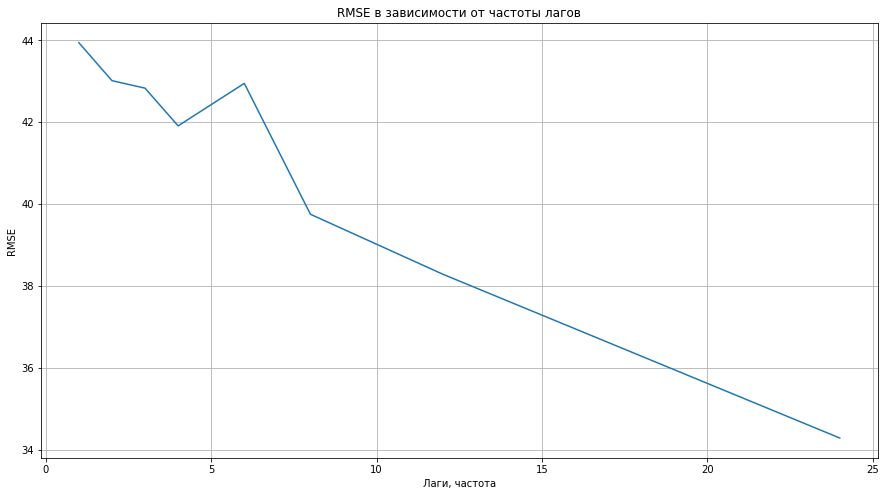

In [22]:
rmse_mem = dict()
for interval in range(13, 0, -1):
    #print(interval)
    lags = [i*interval+1 for i in range(24//interval)]
    
    _, rmse= linear_regression(lags, plot=False)
    rmse_mem[24//interval] = rmse
    
    
plt.figure(figsize=(15, 8))
plt.plot(rmse_mem.keys(), rmse_mem.values())
plt.title(f"RMSE в зависимости от частоты лагов")
plt.xlabel('Лаги, частота')   
plt.ylabel('RMSE')
plt.grid(True)  

Логично - чем больше информации тем лучше

RMSE for linear regression 34.28552123003527
CPU times: user 116 ms, sys: 135 ms, total: 251 ms
Wall time: 262 ms


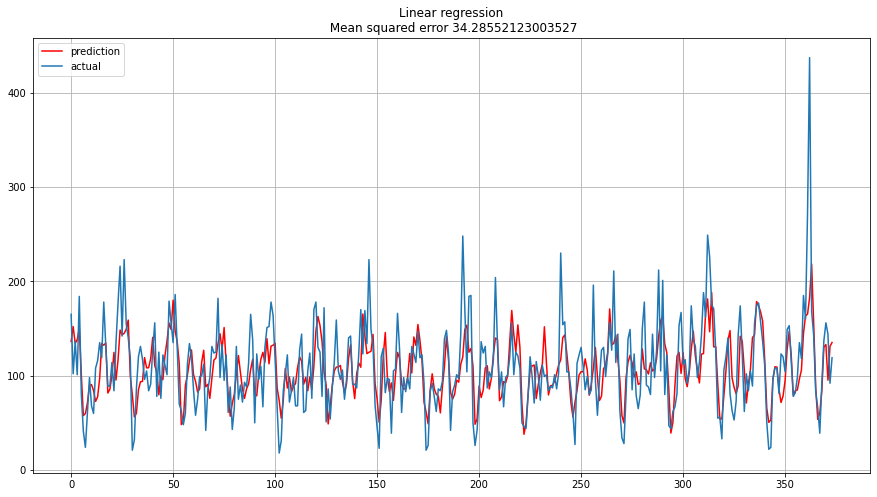

In [23]:
%%time

lags_24 = [i+1 for i in range(24)]
lr_model_24, _ = linear_regression(lags_24)

### XGBoost

In [24]:
def XGB_forecast(data, lags = [1,2,3], test_size=0.1):
    
    # исходные данные
    X_train, X_test, y_train, y_test = prepare_data(data.num_orders, lags, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    
    # задаём параметры
    params = {
        'objective': 'reg:squarederror',
        'booster':'gblinear'
    }
    trees = 100
    
    tscv = TimeSeriesSplit(n_splits=10)
    
    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, 
                dtrain, 
                metrics = ('rmse'), 
                verbose_eval=False, 
                folds=tscv, 
                show_stdv=False, 
                num_boost_round=trees)
    
    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())
    
    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)
    
    # и на тестовом
    prediction_test = bst.predict(dtest)

    xgb_rmse = mean_squared_error(prediction_test, y_test, squared=False)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")

    plt.plot(list(y_test), label="y_test")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title(f"XGBoost root mean squared error {xgb_rmse}")
    
    plt.grid(True)
    plt.legend()
    
    print(f"RMSE for XGBoost: {xgb_rmse}")
    
    # вернем лучшую модель
    return bst

RMSE for XGBoost: 34.38250476627189
CPU times: user 13min 12s, sys: 8.08 s, total: 13min 20s
Wall time: 13min 22s


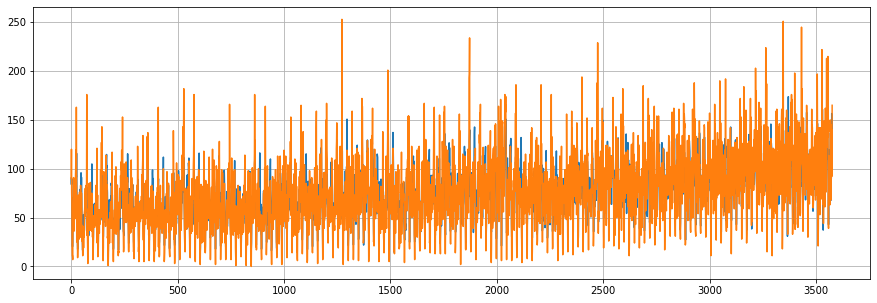

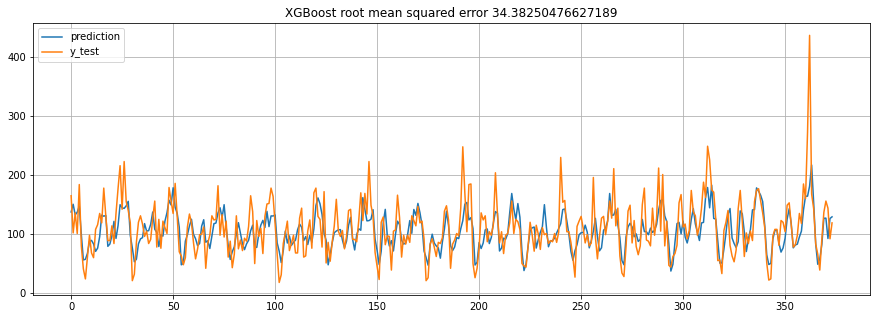

In [25]:
%%time

xgb_model = XGB_forecast(train, test_size=0.1, lags=lags_24)

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Ты сделал lag равный нулю, а это утечка данных.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Поправил

P.S. - я в прошлый раз долго смотрел на слишком хороший результат и думал что у меня где-то течет, но меня переклинило и я не нашел
    
Теперь я передаю тот же набор лагов что и в линейную регрессию
</div>

## Тестирование

Проведем тестирование моделей

### LinearRegression

RMSE for linear regression 45.37114174861035


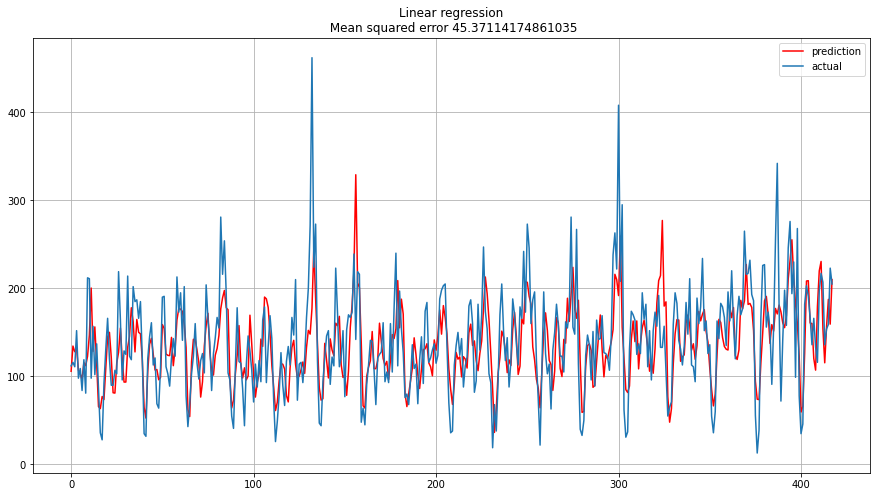

In [26]:
X, y = prepare_data(test.num_orders, lags = lags_24, split=False)

prediction = lr_model_24.predict(X)
linear_rmse_test = mean_squared_error(prediction, y, squared=False)


plt.figure(figsize=(15, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y.values, label="actual")
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean squared error {linear_rmse_test}")
plt.grid(True)
print(f"RMSE for linear regression {linear_rmse_test}")

<div class="alert alert-block alert-success">
<b>Успех:</b> Хорошо, что предсказания были визуализированы!
</div>

### XGBoost

RMSE for XGBoost: 45.703069429012494


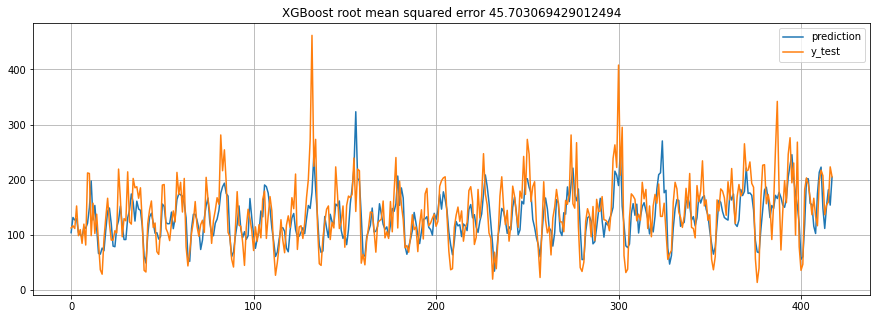

In [27]:
X, y = prepare_data(test.num_orders, lags=lags_24, split=False)


x_test = xgb.DMatrix(X)

prediction_test = xgb_model.predict(x_test)

xgb_rmse_test = mean_squared_error(prediction_test, y, squared=False)


plt.figure(figsize=(15, 5))
plt.plot(prediction_test, label="prediction")

plt.plot(list(y), label="y_test")

plt.legend(loc="best")
plt.axis('tight')
plt.title(f"XGBoost root mean squared error {xgb_rmse_test}")

plt.grid(True)
plt.legend()

print(f"RMSE for XGBoost: {xgb_rmse_test}")

### Результат

In [29]:
index = ['LinearRegression', 'XGBoost',]

result_data = [
    {'time': 0.262, 'rmse': linear_rmse_test},
    {'time': 13*60+22, 'rmse': xgb_rmse_test},
]

result_table = pd.DataFrame(result_data, index=index)
result_table

,time,rmse
LinearRegression,0.262,45.371142
XGBoost,802.000,45.703069


## Вывод

Было проведено сравнение линейной регрессии и градиентного бустинга

В данной задаче и ту и другую модель можно обучить с требуемой точностью, результат очень близок по точности, но XGBoost работает намого медленнее

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48